In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
import os

sys.path.append(os.path.abspath('/mnt/iridia/sehlalou/thesis/iridia_af'))
import hyperparameters as hp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold


import config as cfg
from create_dataset import get_hrv_metrics
from record import Record

In [5]:
metadata_df = pd.read_csv(hp.METADATA_PATH)
metadata_df

,patient_id,patient_sex,patient_age,record_id,record_date,record_start_time,record_end_time,record_timedelta,record_files,record_seconds,record_samples
0,patient_000,female,86,record_000,2012-10-02,2012-10-02T10:50:11,2012-10-03T10:50:02,86391,1,86391,17278200
1,patient_001,female,72,record_001,2011-08-19,2011-08-19T11:19:55,2011-08-21T11:19:54,172799,2,172798,34559600
2,patient_002,male,73,record_002,2012-01-16,2012-01-16T11:29:38,2012-01-17T09:34:22,79484,1,79484,15896800
3,patient_003,female,71,record_003,2017-04-14,2017-04-14T10:18:10,2017-04-15T08:23:04,79494,1,79488,15897790
4,patient_004,female,71,record_004,2008-08-06,2008-08-06T13:01:10,2008-08-07T11:05:49,79479,1,79479,15895800
...,...,...,...,...,...,...,...,...,...,...,...
162,patient_147,male,80,record_162,2016-01-06,2016-01-06T09:32:44,2016-01-07T09:32:43,86399,1,86399,17279800
163,patient_148,female,82,record_163,2009-04-21,2009-04-21T11:55:03,2009-04-25T11:55:02,345599,4,345596,69119200
164,patient_149,female,75,record_164,2010-11-03,2010-11-03T14:11:05,2010-11-04T14:10:56,86391,1,86391,17278200
165,patient_150,male,82,record_165,2010-09-11,2010-09-11T11:20:54,2010-09-13T11:20:53,172799,2,172798,34559600


In [6]:
record_id = "record_104"
metadata_record = metadata_df[metadata_df["record_id"] == record_id]
metadata_record = metadata_record.values[0]
record_path = Path(hp.RECORDS_PATH, record_id)
record = Record(record_path, metadata_record)
record.load_rr_record()

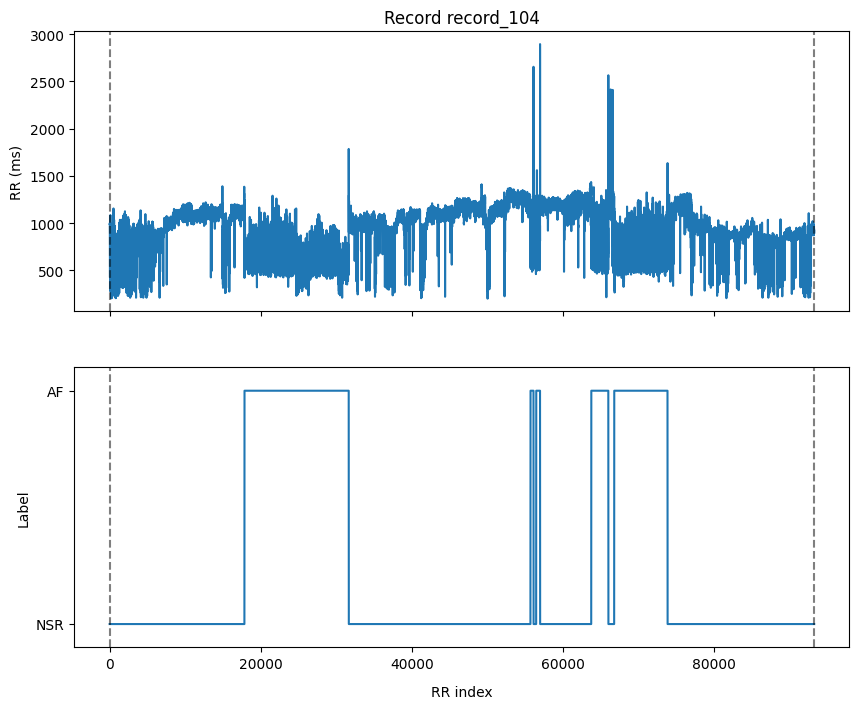

In [7]:
record.plot_rr()

In [8]:
# dataset_path = Path(hp.DATASET_PATH, f"dataset_rr_{hp.WINDOW_SIZE}_2.csv")
dataset_path = Path(hp.DATASET_PATH, f"dataset_hrv_paro_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
list_patient = dataset.patient_id.values
y = dataset.label.values
x = dataset.drop(columns=["label", "patient_id", "record_id", "start_index", "end_index", "file"]).values

/tmp/ipykernel_68077/448784632.py:3: DtypeWarning: Columns (32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataset_path)


In [9]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

In [14]:
metrics = {"roc_auc": [],
           "accuracy": [],
           "sensitivity": [],
           "specificity": [],
           "f1": [],
           "cm": [[0, 0], [0, 0]]
           }

sgkf = StratifiedGroupKFold(n_splits=10, random_state=42, shuffle=True)
for split_id, (train_index, test_index) in enumerate(sgkf.split(x, y, groups=list_patient)):
    print(f"Split {split_id + 1} / {sgkf.n_splits}")
    # model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
    model = xgb.XGBClassifier(objective="binary:logistic",
                              random_state=17, eval_metric="auc",
                              n_estimators=150, max_depth=5,
                              learning_rate=0.2, colsample_bytree=0.8,
                              gamma=0.15, subsample=0.66)
    model.fit(x[train_index], y[train_index])
    y_pred = model.predict(x[test_index])
    y_true = y[test_index]

    cm = confusion_matrix(y_true, y_pred)
    metrics["cm"][0][0] += cm[0][0]
    metrics["cm"][0][1] += cm[0][1]
    metrics["cm"][1][0] += cm[1][0]
    metrics["cm"][1][1] += cm[1][1]

    metrics["roc_auc"].append(roc_auc_score(y_true, y_pred))
    metrics["accuracy"].append((cm[0][0] + cm[1][1]) / sum(sum(cm)))
    metrics["sensitivity"].append(cm[1][1] / (cm[1][1] + cm[1][0]))
    metrics["specificity"].append(cm[0][0] / (cm[0][0] + cm[0][1]))
    metrics["f1"].append(2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0]))

print(f"Confusion matrix: {metrics['cm']}")
mean, lower, upper = mean_confidence_interval(metrics["roc_auc"])
print(f"ROC AUC score: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["accuracy"])
print(f"Accuracy: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["sensitivity"])
print(f"Sensitivity/Recall: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["specificity"])
print(f"Specificity: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["f1"])
print(f"F1 score: {mean:.3f} ({lower:.3f}-{upper:.3f})")

Split 1 / 10
Split 2 / 10
Split 3 / 10
Split 4 / 10
Split 5 / 10
Split 6 / 10
Split 7 / 10
Split 8 / 10
Split 9 / 10
Split 10 / 10
Confusion matrix: [[66449, 27729], [25824, 68354]]
ROC AUC score: 0.720 (0.683-0.758)
Accuracy: 0.719 (0.683-0.754)
Sensitivity/Recall: 0.732 (0.682-0.781)
Specificity: 0.709 (0.638-0.781)
F1 score: 0.721 (0.679-0.763)


In [10]:
from sklearn.ensemble import RandomForestClassifier


metrics = {"roc_auc": [],
           "accuracy": [],
           "sensitivity": [],
           "specificity": [],
           "f1": [],
           "cm": [[0, 0], [0, 0]]
           }

sgkf = StratifiedGroupKFold(n_splits=10, random_state=42, shuffle=True)
for split_id, (train_index, test_index) in enumerate(sgkf.split(x, y, groups=list_patient)):
    print(f"Split {split_id + 1} / {sgkf.n_splits}")
    # model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
    model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42
)
    model.fit(x[train_index], y[train_index])
    y_pred = model.predict(x[test_index])
    y_true = y[test_index]

    cm = confusion_matrix(y_true, y_pred)
    metrics["cm"][0][0] += cm[0][0]
    metrics["cm"][0][1] += cm[0][1]
    metrics["cm"][1][0] += cm[1][0]
    metrics["cm"][1][1] += cm[1][1]

    metrics["roc_auc"].append(roc_auc_score(y_true, y_pred))
    metrics["accuracy"].append((cm[0][0] + cm[1][1]) / sum(sum(cm)))
    metrics["sensitivity"].append(cm[1][1] / (cm[1][1] + cm[1][0]))
    metrics["specificity"].append(cm[0][0] / (cm[0][0] + cm[0][1]))
    metrics["f1"].append(2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0]))

print(f"Confusion matrix: {metrics['cm']}")
mean, lower, upper = mean_confidence_interval(metrics["roc_auc"])
print(f"ROC AUC score: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["accuracy"])
print(f"Accuracy: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["sensitivity"])
print(f"Sensitivity/Recall: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["specificity"])
print(f"Specificity: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["f1"])
print(f"F1 score: {mean:.3f} ({lower:.3f}-{upper:.3f})")

Split 1 / 10
Split 2 / 10
Split 3 / 10
Split 4 / 10
Split 5 / 10
Split 6 / 10
Split 7 / 10
Split 8 / 10
Split 9 / 10
Split 10 / 10
Confusion matrix: [[63274, 30904], [22354, 71824]]
ROC AUC score: 0.720 (0.674-0.766)
Accuracy: 0.721 (0.678-0.764)
Sensitivity/Recall: 0.768 (0.714-0.821)
Specificity: 0.673 (0.589-0.756)
F1 score: 0.731 (0.683-0.779)
